# IBSR_18:Brain Tissue Segmentation Using Deep Learning
Author(s): **Mohammad Imran Hossain, Muhammad Zain Amin**
<br>University of Girona, Spain
<br>Erasmus Mundus Joint Master Degree in Medical Imaging and Applications

# Necessary Libraries

In [1]:
# Import all the necessary libraries
import os
import cv2
import glob
import random
import tqdm 
import scipy.misc
import pandas as pd
import numpy as np
from tqdm import tqdm
import SimpleITK as sitk
from scipy import ndimage
from pathlib import Path
from matplotlib import pyplot as plt
from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from scipy.spatial.distance import directed_hausdorff
from tensorflow.keras import layers, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Input

from keras.optimizers import Adam
import segmentation_models as sm



Segmentation Models: using `keras` framework.


# Import Dataset
- **Load the train and validation dataset from the dirctory**

In [2]:
# Define the path of the train and validation dataset directory
TRAIN_DATA_PATH = Path('D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_23_Brain_Tissue_Segmentation/Dataset/Training_Set')
VALID_DATA_PATH = Path('D:/Erasmus Mundus Masters/University of Girona/Medical Image Segmentation/IBSR_23_Brain_Tissue_Segmentation/Dataset/Validation_Set')

In [3]:
# Define a function to load image dataset from a directory
def load_data(image_size, data_path):
    """
    Load image and label data from a specified directory path.

    Args:
    - image_size : Image dimensions (depth, height, width).
    - data_path  : Path of the directory containing image and label data.

    Returns:
    - images     :  List of images.
                           Shape: (num_images, depth, height, width, channels)
    - labels     :  List of labels.
                           Shape: (num_images, depth, height, width, channels)
    """
    # Count the number of images in the data path
    num_images = len(list(data_path.iterdir()))
    
    # Initialize arrays to store images and labels
    images = np.zeros((num_images, *image_size, 1))  
    labels = np.zeros((num_images, *image_size, 1))  

    # Progress bar initialization
    with tqdm(total=num_images, desc='Loading Progress') as pbar:
        idx = 0  
        # Loop through each image in the data path
        for image_path in data_path.iterdir():
            
            # Extract the image ID and define the image path
            image_id    = image_path.name  
            image_path  = data_path / image_id / f'{image_id}_bias.nii.gz'  
            
            # Read the image and convert into array
            image       = sitk.ReadImage(str(image_path))  
            image_array = sitk.GetArrayFromImage(image)
            image_array = image_array/np.max(image_array)
            image_array = image_array.reshape((*image_size, 1))  
            
            # Define the label path
            label_path  = data_path / image_id / f'{image_id}_seg.nii.gz' 
            
            # Read the label and convert into array
            label       = sitk.ReadImage(str(label_path))  
            label_array = sitk.GetArrayFromImage(label)  
            label_array = label_array.reshape((*image_size, 1))  

            # Insert loaded images and labels into arrays
            images[idx] = image_array
            labels[idx] = label_array
            idx += 1  
            
            pbar.update(1)  

    return (images, labels) 

# Define the image size
IMAGE_SIZE = (256, 128, 256)

# Read train and validation images and corresponding lables
(train_images, train_labels) = load_data(IMAGE_SIZE, TRAIN_DATA_PATH)
(valid_images, valid_labels) = load_data(IMAGE_SIZE, VALID_DATA_PATH)

print('Total Number of Train Image      : ', len(train_images))
print('Total Number of Validation Image : ', len(valid_images))

Loading Progress: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]

Total Number of Train Image      :  10
Total Number of Validation Image :  5


- **Display train and validation images and corresponding labels**

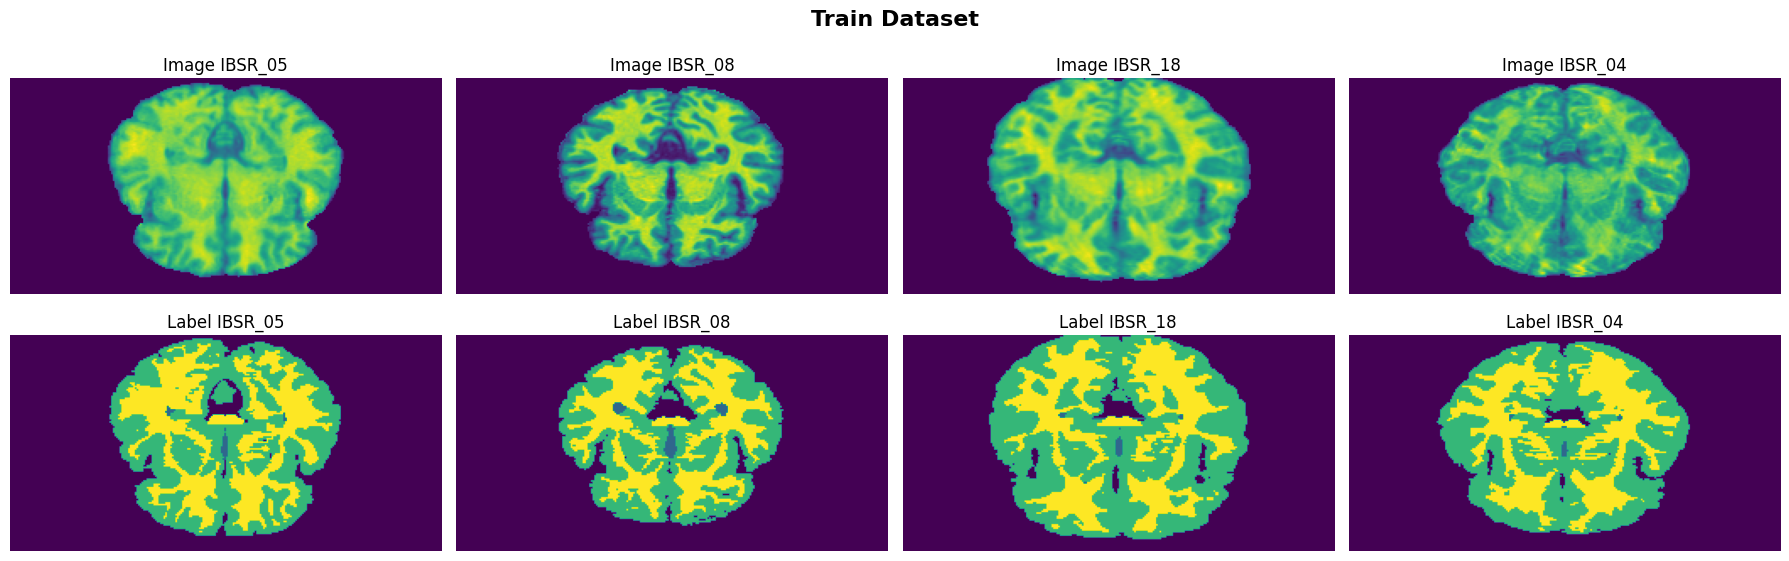

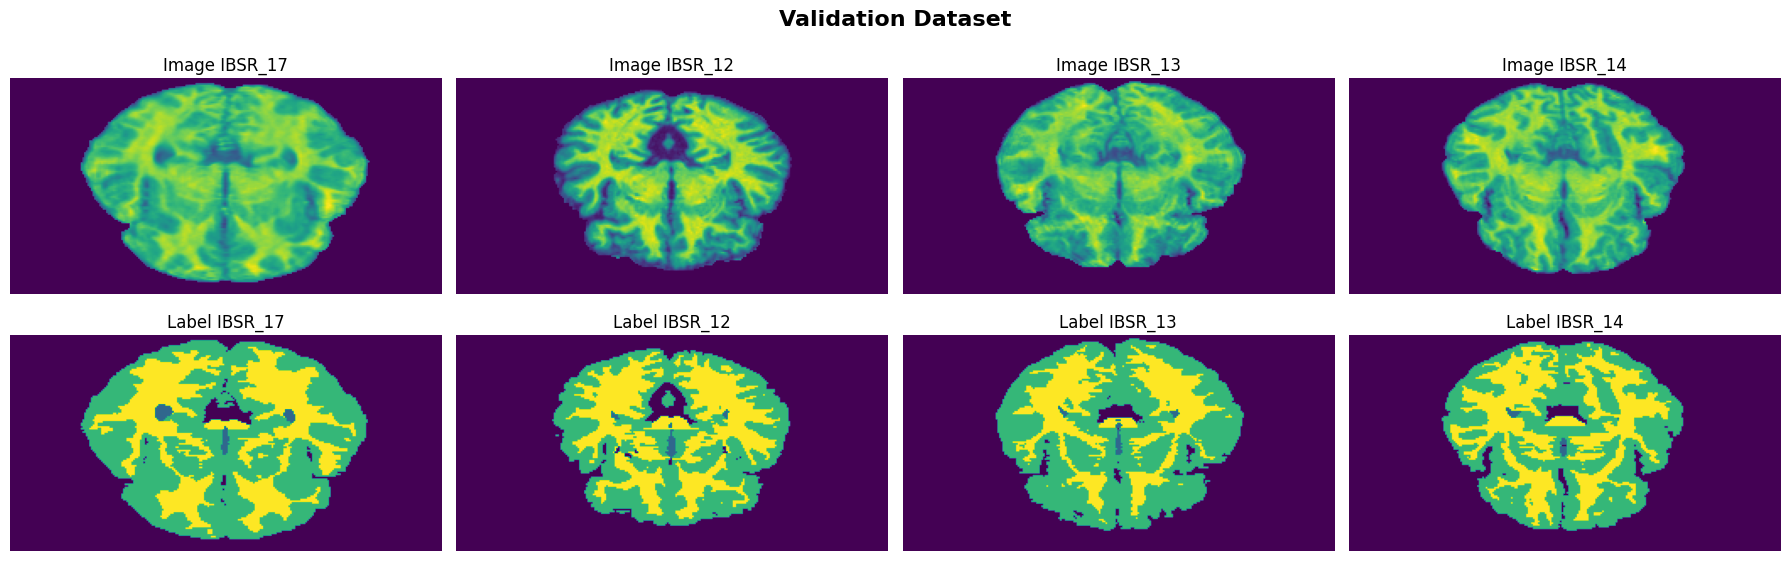

In [4]:
# Define a function to plot images and their corresponding labels
def plot_images_and_labels(images, labels, image_names, num_samples=4, dataset='Training Images'):
    """
    Plot images and their corresponding labels.

    Args:
    - images      : Array of images 
    - labels      : Array of labels 
    - image_names : List of image names or identifiers
    - num_samples : Number of samples to plot
    - dataset     : Type of Dataset
    """
    
    # Set the figure size
    plt.figure(figsize=(18, 6))
    
    # Define the slice number
    slice_num = 125

    # Select random indices for samples to plot
    random_indices = random.sample(range(len(images)), num_samples)

    # Iterate through the selected random indices
    for i, idx in enumerate(random_indices, 1):
        # Plot the image
        plt.subplot(2, num_samples, i)
        plt.imshow(images[idx, slice_num, :, :], cmap='viridis')  
        plt.title(f"Image {image_names[idx]}")  
        plt.axis('off')  

        # Plot the label
        plt.subplot(2, num_samples, i + num_samples)
        plt.imshow(labels[idx, slice_num, :, :], cmap='viridis')  
        plt.title(f"Label {image_names[idx]}")  
        plt.axis('off')  

    # Set a super title for the entire plot
    plt.suptitle(dataset, fontsize=16, fontweight='bold')
    plt.tight_layout()  
    plt.show()  


# Plot train images and corresponding labels
train_image_names = os.listdir(TRAIN_DATA_PATH)
plot_images_and_labels(train_images, train_labels, train_image_names, dataset='Train Dataset')

# Plot validation images and corresponding labels
valid_image_names = os.listdir(VALID_DATA_PATH)
plot_images_and_labels(valid_images, valid_labels, valid_image_names, dataset='Validation Dataset')

# Data Pre-processing
- **Split train dataset into training and training-validation for deep learning model**

In [5]:
# Split train dataset into training and validation (80:20)
training_images   = train_images[:8]
training_labels   = train_labels[:8]

validation_images = train_images[-2:]
validation_labels = train_labels[-2:]

print('Total Number of Training Image            :', len(training_images))
print('Total Number of Training-Validation Image :', len(validation_images))

Total Number of Training Image            : 8
Total Number of Training-Validation Image : 2


- **Extract patches from both the training and traininng-validation images and corresponding labels**

In [6]:
# Define required parameters for patch extraction
IMAGE_SIZE        = (256, 128, 256)  
PATCH_SIZE        = (32, 32)         
PATCH_STRIDE      = (32, 32)         
BATCH_SIZE        = 64              
N_CLASSES         = 4                
N_INPUT_CHANNELS  = 1                
CONTENT_THRESHOLD = 0.3    

# Define a function to extract patches from images and labels
def extract_patches(images, 
                    labels, 
                    image_size  = IMAGE_SIZE, 
                    patch_size  = PATCH_SIZE, 
                    stride      = PATCH_STRIDE, 
                    threshold   = CONTENT_THRESHOLD, 
                    num_classes = N_CLASSES):
    
    """
    Extracts patches from input images and labels.

    Args:
    - images     : Input images.
    - labels     : Corresponding labels for the input images.
    - image_size : Dimensions of the input images (slice, height, width).
    - patch_size : Dimensions of the patches to be extracted (height, width).
    - stride     : Dimensions of the stride for patch extraction (vertical stride, horizontal stride).
    - threshold  : Threshold value to determine the usefulness of extracted patches.
    - num_classes: Number of classes in the dataset.

    Returns:
    - useful_image_patches: Extracted patches from input images.
    - useful_label_patches: Extracted patches from labels of the corresponding input images.
    """

    # Reshape images and labels for patch extraction
    images_reshaped = images.reshape([-1, image_size[1], image_size[2], 1])
    labels_reshaped = labels.reshape([-1, image_size[1], image_size[2], 1])

    # Extract patches from images
    image_patches = tf.image.extract_patches(
        images_reshaped,
        sizes   = [1, patch_size[0], patch_size[1], 1],
        strides = [1, stride[0], stride[1], 1],
        rates   = [1, 1, 1, 1],
        padding = 'SAME'
    ).numpy()

    # Extract patches from labels
    label_patches = tf.image.extract_patches(
        labels_reshaped,
        sizes   = [1, patch_size[0], patch_size[1], 1],
        strides = [1, stride[0], stride[1], 1],
        rates   = [1, 1, 1, 1],
        padding = 'SAME'
    ).numpy()

    # Reshape patches for further processing
    image_patches = image_patches.reshape([-1, *patch_size, 1])
    label_patches = label_patches.reshape([-1, *patch_size])

    # Masking to retain only foreground patches
    foreground_mask = label_patches != 0
    patch_product   = np.prod(patch_size)

    # Check for useful patches based on the threshold
    useful_patches = foreground_mask.sum(axis=(1, 2)) > threshold * patch_product

    # Filter patches based on usefulness
    useful_image_patches = image_patches[useful_patches]
    useful_label_patches = label_patches[useful_patches]

    # Convert label patches to one-hot encoded format
    useful_label_patches = tf.keras.utils.to_categorical(useful_label_patches, num_classes=num_classes, dtype='float32')

    return useful_image_patches, useful_label_patches

# Extract patches from training and validation images along with their corresponding labels
(training_image_patches, training_label_patches)     = extract_patches(training_images, training_labels)
(validation_image_patches, validation_label_patches) = extract_patches(validation_images, validation_labels)

print('Total Number of Patches from Training Images   : ', len(training_image_patches))
print('Total Number of Patches from Validation Images : ', len(validation_image_patches))

Total Number of Patches from Training Images   :  9088
Total Number of Patches from Validation Images :  3700


- **Display some random patches for the vizualization**

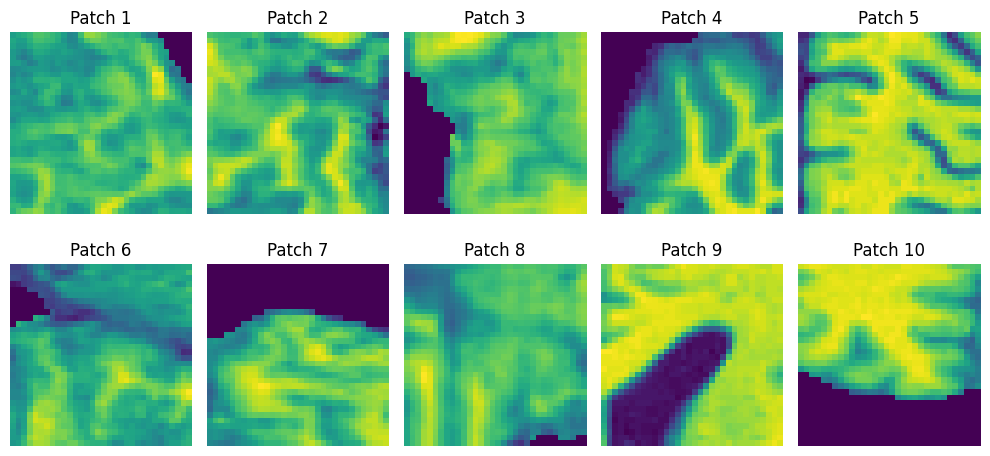

In [7]:
# Define the number of patches to plot
num_patches = 10

# Randomly select patches to plot
random_indices = np.random.choice(len(training_image_patches), num_patches, replace=False)

# Create a figure to plot the patches
plt.figure(figsize=(10, 5))

# Loop through each patch to plot
for i in range(num_patches):
    plt.subplot(2, 5, i + 1)  
    patch_index   = random_indices[i]  
    patch_to_plot = training_image_patches[patch_index]  
    plt.imshow(patch_to_plot, cmap='viridis')  
    plt.axis('off')  
    plt.title(f'Patch {i+1}')  

plt.tight_layout()  
plt.show()  

# Data Augmentation
- **Augment the training and training-validation dataset to handle data imbalance**

In [8]:
# Degree of Augmentation
DEGREE = 0.2

# Create the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range     = 40,            
    width_shift_range  = DEGREE,    
    height_shift_range = DEGREE,                
    shear_range        = DEGREE,          
    zoom_range         = DEGREE,            
    horizontal_flip    = True,        
    vertical_flip      = True,           
    fill_mode          ='nearest'  # fill_mode options: 'constant', 'nearest', 'reflect', 'wrap'
   
)

# Generate augmented training data and labels 
train_generator = datagen.flow(
    training_image_patches,
    batch_size=int(training_image_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

train_label_generator = datagen.flow(
    training_label_patches,
    batch_size=int(training_label_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

# Generate augmented training-validation data and labels 
validation_generator = datagen.flow(
    validation_image_patches,
    batch_size=int(validation_image_patches.shape[0] / BATCH_SIZE),  
    seed=1 
)

validation_label_generator = datagen.flow(
    validation_label_patches,
    batch_size=int(validation_label_patches.shape[0] / BATCH_SIZE),  
    seed=1  
)

In [9]:
# Retrieve batches of augmented data from the generators
X_train = train_generator.next()  
Y_train = train_label_generator.next()  

# Concatenate original and augmented data for the training set
total_train_images = np.concatenate((training_image_patches, X_train))
total_train_labels = np.concatenate((training_label_patches, Y_train))

# Retrieve batches of augmented data for the validation set
X_validation = validation_generator.next()  
Y_validation = validation_label_generator.next()  

# Concatenate original and augmented data for the validation set
total_validation_images = np.concatenate((validation_image_patches, X_validation))
total_validation_labels = np.concatenate((validation_label_patches, Y_validation))

# Display shapes of the datasets
print('---------Training Dataset----------')
print('Shape of Image Patches:', total_train_images.shape)
print('Shape of Label Patches:', total_train_labels.shape)

print('\n---------Validation Dataset----------')
print('Shape of Image Patches:', total_validation_images.shape)
print('Shape of Label Patches:', total_validation_labels.shape)


---------Training Dataset----------
Shape of Image Patches: (9230, 32, 32, 1)
Shape of Label Patches: (9230, 32, 32, 4)

---------Validation Dataset----------
Shape of Image Patches: (3757, 32, 32, 1)
Shape of Label Patches: (3757, 32, 32, 4)


In [10]:
# Convert grayscale training images into 3 channel images for the model training
total_train_images = np.array(total_train_images).reshape(9230, 32, 32)
total_train_images_rgb = np.stack((total_train_images,) * 3, axis=-1)

# Convert grayscale validation images into 3 channel images for the model training
total_validation_images = np.array(total_validation_images).reshape(3757, 32, 32)
total_validation_images_rgb = np.stack((total_validation_images,) * 3, axis=-1)


# Display shapes of the datasets
print('---------Dataset----------')
print('Shape of Training Image Patches  :', total_train_images_rgb.shape)
print('Shape of Validation Image Patches:', total_validation_images_rgb.shape)


---------Dataset----------
Shape of Training Image Patches  : (9230, 32, 32, 3)
Shape of Validation Image Patches: (3757, 32, 32, 3)


# ResNet50-UNet Model

In [11]:
# Define training parameters
N_EPOCHS      = 30
BATCH_SIZE    = 64
LEARNING_RATE = 0.001
BACKBONE      = 'resnet50'
ACTIVATION    = 'softmax'
OPTIMIZER     = Adam(LEARNING_RATE)

# Define the loss 
dice_loss  = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
focal_loss = sm.losses.CategoricalCELoss()
LOSS       = dice_loss + (1*focal_loss)

# Define the performance metrics
metrics  = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Preprocess the data according to the training backbone
preprocess_input = sm.get_preprocessing(BACKBONE)

# Apply the preprocessed on the training and validation data
total_train_images_preprocessed      = preprocess_input(total_train_images_rgb)
total_validation_images_preprocessed = preprocess_input(total_validation_images_rgb)

# Define the ResNet50-UNet model
resnet50_unet_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation='softmax')

# Compline the model
resnet50_unet_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=metrics)

# Print the model summary
print(resnet50_unet_model.summary())



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                          

- **Train ResNet50-UNet Model**

In [12]:
# Train the ResNet50-UNet Model
history = resnet50_unet_model.fit(total_train_images_preprocessed,
                            total_train_labels,
                            batch_size = BATCH_SIZE,
                            epochs     = N_EPOCHS,
                            verbose    = 1,
                            validation_data= (total_validation_images_preprocessed, total_validation_labels)
                               )

Epoch 1/30


145/145 [==============================] - 304s 2s/step - loss: 0.9506 - iou_score: 0.5998 - f1-score: 0.6895 - val_loss: 1.3617 - val_iou_score: 0.1886 - val_f1-score: 0.2344
Epoch 2/30
145/145 [==============================] - 245s 2s/step - loss: 0.8516 - iou_score: 0.7865 - f1-score: 0.8758 - val_loss: 1.5927 - val_iou_score: 0.1866 - val_f1-score: 0.2279
Epoch 3/30
145/145 [==============================] - 236s 2s/step - loss: 0.8292 - iou_score: 0.8368 - f1-score: 0.9100 - val_loss: 1.8556 - val_iou_score: 0.1866 - val_f1-score: 0.2279
Epoch 4/30
145/145 [==============================] - 237s 2s/step - loss: 0.8264 - iou_score: 0.8396 - f1-score: 0.9116 - val_loss: 1.7586 - val_iou_score: 0.1446 - val_f1-score: 0.1900
Epoch 5/30
145/145 [==============================] - 238s 2s/step - loss: 0.8169 - iou_score: 0.8605 - f1-score: 0.9243 - val_loss: 1.6116 - val_iou_score: 0.2412 - val_f1-score: 0.3142
Epoch 6/30
145/145 [==============================] - 240s 2s/s

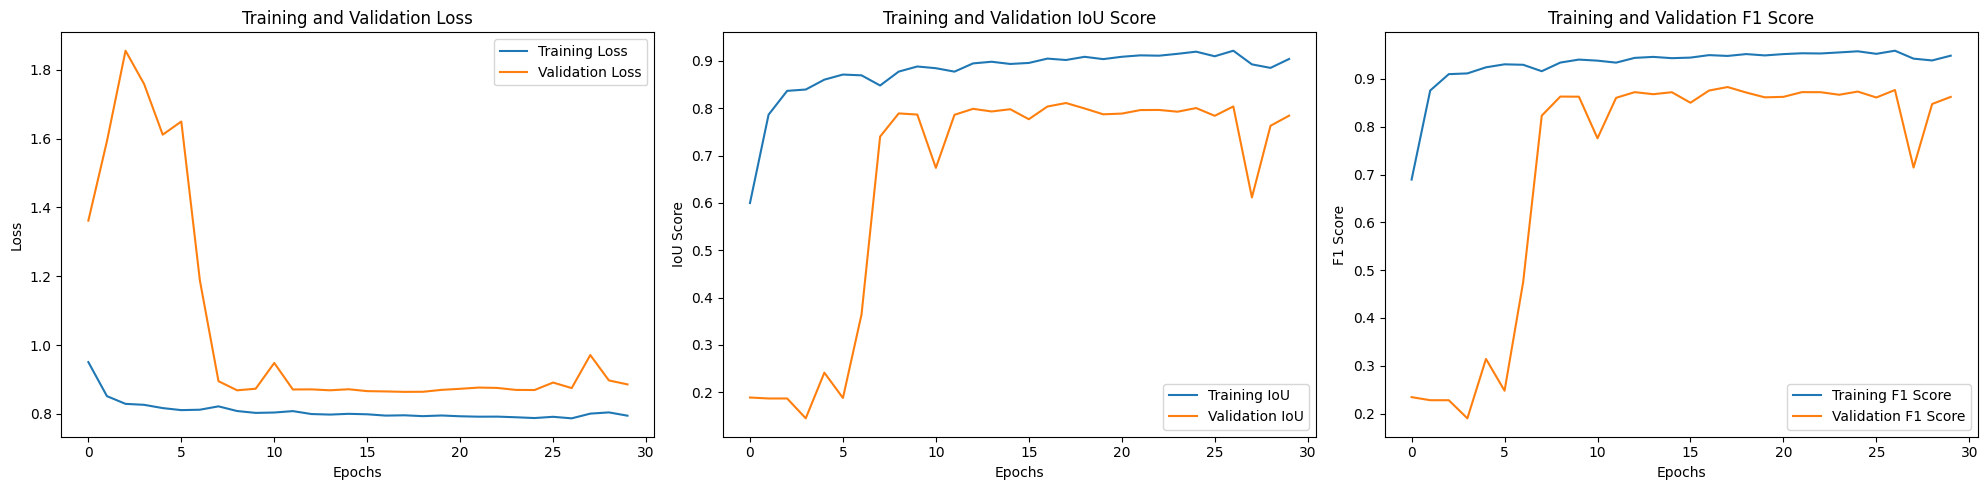

In [13]:
# Accessing metrics from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_iou = history.history['iou_score']
validation_iou = history.history['val_iou_score']
training_f1 = history.history['f1-score']
validation_f1 = history.history['val_f1-score']

# Creating subplots in a 1x3 grid
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plotting Loss
axs[0].plot(training_loss, label='Training Loss')
axs[0].plot(validation_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting IOU Score
axs[1].plot(training_iou, label='Training IoU')
axs[1].plot(validation_iou, label='Validation IoU')
axs[1].set_title('Training and Validation IoU Score')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('IoU Score')
axs[1].legend()

# Plotting F1 Score
axs[2].plot(training_f1, label='Training F1 Score')
axs[2].plot(validation_f1, label='Validation F1 Score')
axs[2].set_title('Training and Validation F1 Score')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('F1 Score')
axs[2].legend()

plt.tight_layout()
plt.show()

# Test Prediction
- **Prepare the validation that for making the prediction using the trained models**

In [14]:
# Define a function to prepare validation data for prediction using the trained model
def prepare_valid_data(valid_images, valid_labels):
    """
    Prepare validation data for prediction by reshaping images and labels.

    Args:
    - valid_images : Validation images data.
    - valid_labels : Validation labels data.

    Returns:
    - valid_images_reshaped: Reshaped validation images.
    - valid_labels_modified: Modified validation labels.
    """
    
    # Reshape the valid images and labels to match the required input shape for the model
    valid_images_reshaped = valid_images.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
    valid_labels_reshaped = valid_labels.reshape([-1, IMAGE_SIZE[1], IMAGE_SIZE[2], 1])
    
    # Modify the validation labels to categorical format suitable for model prediction
    valid_labels_modified = tf.keras.utils.to_categorical(valid_labels_reshaped, num_classes=4, dtype='float32')
    
    return valid_images_reshaped, valid_labels_modified


- **Predict the validation dataset using trained DenseUNet Model**

In [15]:
# Define lists to store processed validation labels and validation predictions 
valid_processed_labels = []  
valid_predictions      = []       

# Iterate through each validation image and label
for i in range(len(valid_images)):
    
    # Prepare the individual validation image and label for the prediction using trained model
    pre_valid_image, pre_valid_label = prepare_valid_data(valid_images[i], valid_labels[i])

    # Convert grayscale validation images into 3 channel images for the model training
    pre_valid_image = np.array(pre_valid_image).reshape(256, 128, 256)
    pre_valid_image_rgb = np.stack((pre_valid_image,) * 3, axis=-1)

    # Get predictions using the trained DenseU-Net model for the prepared validation image
    prediction = resnet50_unet_model.predict(x=pre_valid_image_rgb)
    
    # Transform the prediction to obtain the predicted class indices
    prediction = np.argmax(prediction, axis=3)
    
    # Append the predicted labels and processed validation labels to their respective lists
    valid_predictions.append(prediction)
    valid_processed_labels.append(pre_valid_label)


8/8 [==============================] - 23s 3s/step


- **Map the prediction result to each class (background, CSF, WM, GM)**

In [16]:
# Define list to store processed predictions
valid_processed_predictions = []  

# Function to map predicted values to separate channels for each class
def map_predictions_to_channels(predictions):
    """
    Map predicted values to separate channels for each class.

    Args:
    - predictions      : Predicted values.

    Returns:
    - final_prediction : Prediction result.
    """
    # Create empty arrays for each class based on predictions
    background = np.where(predictions == 0, 1, 0)          # Set background values to 1, others to 0
    csf        = np.where(predictions == 1, 1, 0)          # Set CSF values to 1, others to 0
    gm         = np.where(predictions == 2, 1, 0)          # Set GM values to 1, others to 0
    wm         = np.where(predictions == 3, 1, 0)          # Set WM values to 1, others to 0
    
    # Stack the channels together to create a 4-channel prediction result
    final_prediction = np.stack([background, csf, gm, wm], axis=-1)
    
    return final_prediction.astype(np.float32) 


for i in range(len(valid_images)):
    
    # Convert current predictions to match the desired format using the mapping function
    valid_processed_prediction = map_predictions_to_channels(valid_predictions[i])
    valid_processed_predictions.append(valid_processed_prediction)


In [17]:
print('Shape of the predictions: ',valid_processed_predictions[1].shape)
print('Shape of the labels     : ',valid_processed_labels[1].shape)

Shape of the predictions:  (256, 128, 256, 4)
Shape of the labels     :  (256, 128, 256, 4)


- **Display some random segmentation result with their corresponding groundtruth**

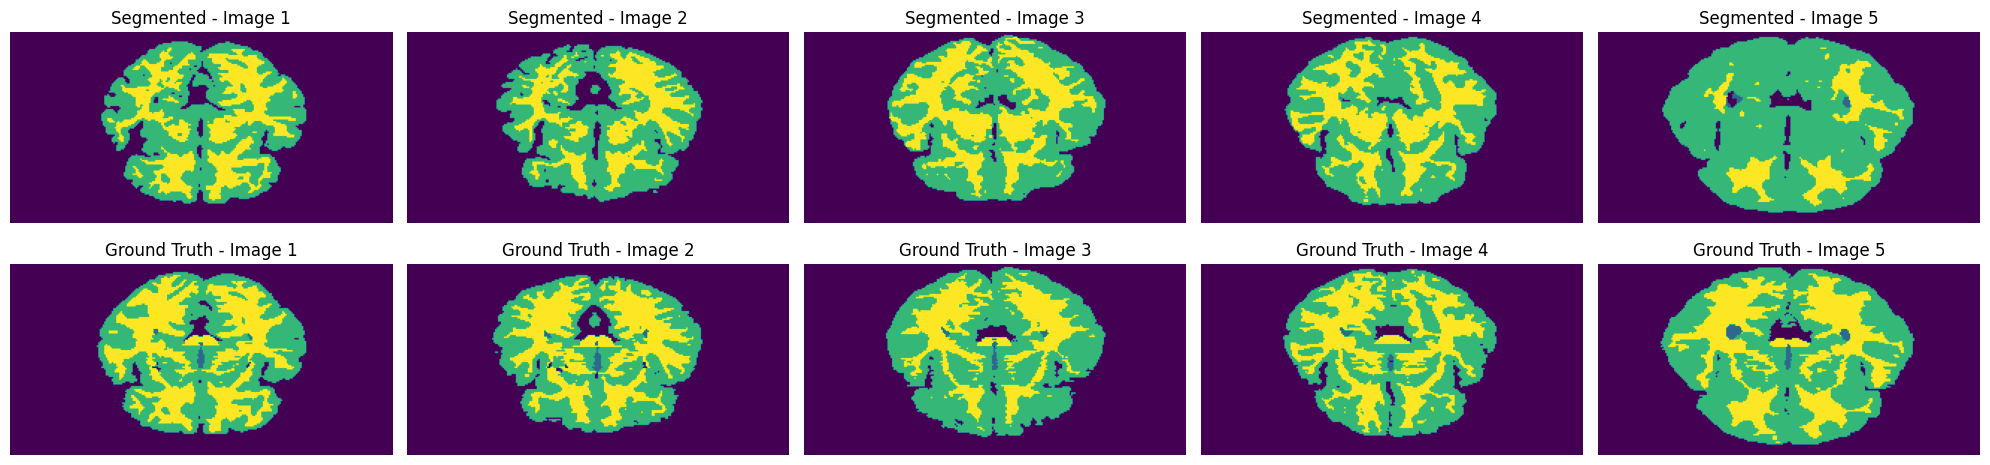

In [18]:
# Select 5 random indices for images to plot
indices = random.sample(range(len(valid_processed_labels)), 5)

# Plot the images
plt.figure(figsize=(20, 5))

for i, index in enumerate(indices, 1):
    
    # Plot segmented images
    plt.subplot(2, 5, i)
    plt.imshow(valid_processed_predictions[index][125,:,:,:].argmax(axis=-1), cmap='viridis')  
    plt.title(f'Segmented - Image {index + 1}')
    plt.axis('off')
    
    # Plot groundtruth 
    plt.subplot(2, 5, i + 5)
    plt.imshow(valid_labels[index][125,:,:,:], cmap='viridis')  
    plt.title(f'Ground Truth - Image {index + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Performance Evaluation

In [19]:
def dice_score(prediction, ground_truth):
    """
    Calculate Dice coefficients for each class between prediction and ground truth.

    Args:
    - prediction    : Predicted values.
    - ground_truth  : Ground truth values.

    Returns:
    - scores        : List containing Dice coefficients for each class.
    """
    
    # Define list to store Dice coefficients for each class
    scores = []  
    
    for i in range(N_CLASSES):
        
        # Seperate class channels
        prediction_each_class = prediction[:, :, :, i]
        ground_truth_each_class = ground_truth[:, :, :, i]

        # Flatten the images to 1D arrays
        prediction_flat = prediction_each_class.flatten()
        ground_truth_flat = ground_truth_each_class.flatten()

        # Calculate intersection, union, and Dice coefficient
        intersection = np.sum(prediction_flat * ground_truth_flat)
        union = np.sum(prediction_flat) + np.sum(ground_truth_flat)
        score = (2.0 * intersection) / (union + 1e-8)  
        scores.append(score)
        
    return scores


def compute_hausdorff_distance(predictions, labels):
    classes = ['Background', 'CSF', 'GM', 'WM']
    distances = {}

    for i, class_name in enumerate(classes):
        # Extract masks for the specific class
        pred_mask = predictions[:,:,:,i]
        label_mask = labels[:,:,:,i]

        # Find coordinates where the mask is True
        pred_coordinates = np.argwhere(pred_mask)
        label_coordinates = np.argwhere(label_mask)

        # Compute Hausdorff Distance
        if len(pred_coordinates) > 0 and len(label_coordinates) > 0:
            distance = directed_hausdorff(pred_coordinates, label_coordinates)[0]
            distances[class_name] = distance
        else:
            distances[class_name] = np.nan  # Set to NaN if no points in the mask

    return distances


def compute_avd(predictions, labels):
    classes = ['Background', 'CSF', 'GM', 'WM']
    avd = {}

    for i, class_name in enumerate(classes):
        # Extract masks for the specific class
        pred_mask = predictions[:,:,:,i]
        label_mask = labels[:,:,:,i]

        # Compute volumes
        pred_volume = np.sum(pred_mask)
        label_volume = np.sum(label_mask)

        # Compute Absolute Volume Difference (AVD)
        avd[class_name] = abs(pred_volume - label_volume)

    return avd


In [20]:
# Define list to store Dice coefficients for each image
dice_scores = []  

# Iterate over segemented images to compute dice score
for i in range(len(valid_processed_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    dice_coeff = dice_score(valid_processed_predictions[i], valid_processed_labels[i])
    dice_scores.append(dice_coeff)

# Create a Pandas DataFrame to display the Dice coefficients
dice_scores_df = pd.DataFrame(dice_scores)
dice_scores_df.columns = ['Background', 'CSF', 'GM', 'WM']  
print('Dice Scores:')
dice_scores_df

Dice Scores:


,Background,CSF,GM,WM
0,0.992958,0.608816,0.815678,0.810850
1,0.993764,0.702911,0.836590,0.817369
2,0.995774,0.563661,0.858590,0.792560
3,0.993150,0.700741,0.885792,0.864926
4,0.990776,0.538328,0.828416,0.535711


In [21]:
# Define list to store Hausdorff Distance for each image
hd_distances = []  

# Iterate over segemented images to compute dice score
for i in range(len(valid_processed_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    hd_distance = compute_hausdorff_distance(valid_processed_predictions[i], valid_processed_labels[i])
    hd_distances.append(hd_distance)

# Create a Pandas DataFrame to display the Dice coefficients
hd_distances_df = pd.DataFrame(hd_distances)
hd_distances_df.columns = ['Background', 'CSF', 'GM', 'WM']  
print('Hausdorff Distances:')
hd_distances_df

Hausdorff Distances:


,Background,CSF,GM,WM
0,22.315914,35.298725,13.601471,10.392305
1,18.973666,26.870058,14.456832,10.723805
2,23.790755,20.518285,13.190906,14.456832
3,22.869193,24.677925,14.177447,9.000000
4,26.476405,9.219544,15.132746,13.152946


In [22]:
# Define list to store Hausdorff Distance for each image
volumn_differences = []  

# Iterate over segemented images to compute dice score
for i in range(len(valid_processed_predictions)): 
    
    # Calculate Dice coefficients for each class between predicted and ground truth images
    volumn_difference = compute_avd(valid_processed_predictions[i], valid_processed_labels[i])
    volumn_differences.append(volumn_difference)

# Create a Pandas DataFrame to display the Dice coefficients
volumn_differences_df = pd.DataFrame(volumn_differences)
volumn_differences_df.columns = ['Background', 'CSF', 'GM', 'WM']  
print('Volumn Differences:')
volumn_differences_df


Volumn Differences:


,Background,CSF,GM,WM
0,74622.0,4926.0,14471.0,84167.0
1,65292.0,6134.0,301.0,58857.0
2,10138.0,6166.0,81959.0,77987.0
3,51307.0,5457.0,16414.0,29436.0
4,67262.0,15204.0,227720.0,279778.0


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class_names = ['Background', 'CSF', 'GM', 'WM']

# Assuming dice_scores_df, hd_distances_df, and volumn_differences_df are DataFrames containing relevant data

# Calculate statistics for Dice Scores
dice_stats = pd.DataFrame(index=class_names)
dice_stats['Mean'] = dice_scores_df.mean()
dice_stats['Standard Deviation'] = dice_scores_df.std()
dice_stats.loc['Overall'] = [dice_scores_df.values.mean(), dice_scores_df.values.std()]

# Calculate statistics for HD distances
hd_stats = pd.DataFrame(index=class_names)
hd_stats['Mean'] = hd_distances_df.mean()
hd_stats['Standard Deviation'] = hd_distances_df.std()
hd_stats.loc['Overall'] = [hd_distances_df.values.mean(), hd_distances_df.values.std()]

# Calculate statistics for volume differences
vol_stats = pd.DataFrame(index=class_names)
vol_stats['Mean'] = volumn_differences_df.mean()
vol_stats['Standard Deviation'] = volumn_differences_df.std()
vol_stats.loc['Overall'] = [volumn_differences_df.values.mean(), volumn_differences_df.values.std()]

# Display DataFrames
print("Dice Scores Statistics:")
print(dice_stats)
print("\n\nHD Distances Statistics:")
print(hd_stats)
print("\n\nVolume Differences Statistics:")
print(vol_stats)


Dice Scores Statistics:
                Mean  Standard Deviation
Background  0.993284            0.001792
CSF         0.622891            0.076356
GM          0.845013            0.027632
WM          0.764283            0.130538
Overall     0.806368            0.150645


HD Distances Statistics:
                 Mean  Standard Deviation
Background  22.885186            2.708377
CSF         23.316907            9.547371
GM          14.111880            0.754017
WM          11.545178            2.210450
Overall     17.964788            6.929386


Volume Differences Statistics:
                     Mean  Standard Deviation
Background   53724.199219        25784.703125
CSF           7577.399902         4294.371094
GM           68173.000000        94624.000000
WM          106045.000000        99429.250000
Overall      58879.898438        71742.546875


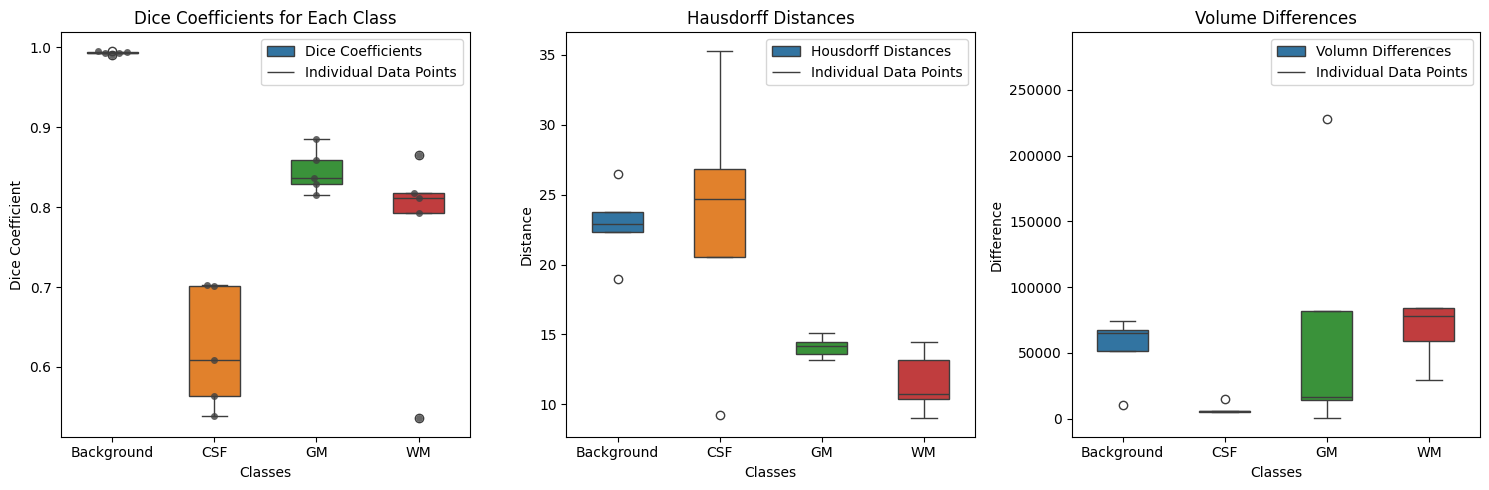

In [24]:
# Create subplots for the three boxplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plotting boxplot and swarmplot for Dice Coefficients
sns.boxplot(data=dice_scores_df[class_names], width=0.5, ax=axes[0])
sns.swarmplot(data=dice_scores_df[class_names], color=".25", alpha=0.8, ax=axes[0])
axes[0].set_title('Dice Coefficients for Each Class')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Dice Coefficient')
axes[0].set_xticks(range(len(class_names)))  # Set the ticks
axes[0].set_xticklabels(class_names)  # Assign the tick labels
axes[0].legend(['Dice Coefficients', 'Individual Data Points'], loc='upper right')

# Plotting boxplot for HD distances
sns.boxplot(data=hd_distances_df, width=0.5, ax=axes[1])
axes[1].set_title('Hausdorff Distances')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Distance')
axes[1].set_xticks(range(len(class_names)))  # Set the ticks
axes[1].set_xticklabels(class_names)  # Assign the tick labels
axes[1].legend(['Housdorff Distances', 'Individual Data Points'], loc='upper right')

# Plotting boxplot for volume differences
sns.boxplot(data=volumn_differences_df, width=0.5, ax=axes[2])
axes[2].set_title('Volume Differences')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Difference')
axes[2].set_xticks(range(len(class_names)))  # Set the ticks
axes[2].set_xticklabels(class_names)  # Assign the tick labels
axes[2].legend(['Volumn Differences', 'Individual Data Points'], loc='upper right')

plt.tight_layout()
plt.show()

# VGG15-UNet Model

In [ ]:
# Define training parameters
N_EPOCHS      = 50
BATCH_SIZE    = 64
LEARNING_RATE = 0.001
BACKBONE      = 'vgg16'
ACTIVATION    = 'softmax'
OPTIMIZER     = Adam(LEARNING_RATE)

# Define the loss 
dice_loss  = sm.losses.DiceLoss(class_weights=np.array([0.25,0.25,0.25,0.25]))
focal_loss = sm.losses.CategoricalCELoss()
LOSS       = dice_loss + (1*focal_loss)

# Define the performance metrics
metrics  = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# Preprocess the data according to the training backbone
preprocess_input = sm.get_preprocessing(BACKBONE)

# Apply the preprocessed on the training and validation data
total_train_images_preprocessed      = preprocess_input(total_train_images_rgb)
total_validation_images_preprocessed = preprocess_input(total_validation_images_rgb)

# Define the ResNet50-UNet model
vgg16_unet_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=N_CLASSES, activation='softmax')

# Compline the model
vgg16_unet_model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=metrics)

# Print the model summary
print(vgg16_unet_model.summary())

In [ ]:
# Train the ResNet50-UNet Model
history = vgg16_unet_model.fit(total_train_images_preprocessed,
                            total_train_labels,
                            batch_size = BATCH_SIZE,
                            epochs     = N_EPOCHS,
                            verbose    = 1,
                            validation_data= (total_validation_images_preprocessed, total_validation_labels)
                               )

# Result Summary

In [204]:
# Sample data (replace these with your actual data)
model_name = "ResNet36-UNet"

dice_scores = {
    'Background': 0.997,
    'CSF': 0.822,
    'GM': 0.902,
    'WM': 0.872
}

houssfield_distances = {
    'Background': 15.99,
    'CSF': 26.11,
    'GM': 19.62,
    'WM': 11.15
}

avd = {
    'Background': 14535,
    'CSF': 2246,
    'GM': 53023,
    'WM': 43089
}

# Add values for Trial 1
trial_1_details = [
    ["Trial", "Trail - 1", "", "", "",""],
    ["Model", model_name, "", "", "",""],
    ["Parameters", "Epochs = 50; Batch Size = 60; LR = 0.0001; Optimizer = Adam", "", "", "",""],
    ["Dataset", "Validation Dataset", "", "", ""],
    ["Class", "","Background", "CSF", "GM", "WM"],
    ["Dice Score (Mean)"] + [""] + [dice_scores['Background']] + [dice_scores[key] for key in ['CSF', 'GM', 'WM']],
    ["Houssfield Distance (Mean)"] + [""] + [houssfield_distances[key] for key in ['Background', 'CSF', 'GM', 'WM']],
    ["AVD (Mean)"] + [""] + [avd[key] for key in ['Background', 'CSF', 'GM', 'WM']],

]

# Create and display the table using tabulate
print(tabulate(trial_1_details, headers="firstrow", tablefmt="pretty"))

+----------------------------+-------------------------------------------------------------+------------+-------+-------+-------+
|           Trial            |                          Trail - 1                          |            |       |       |       |
+----------------------------+-------------------------------------------------------------+------------+-------+-------+-------+
|           Model            |                        ResNet36-UNet                        |            |       |       |       |
|         Parameters         | Epochs = 50; Batch Size = 60; LR = 0.0001; Optimizer = Adam |            |       |       |       |
|          Dataset           |                     Validation Dataset                      |            |       |       |       |
|           Class            |                                                             | Background |  CSF  |  GM   |  WM   |
|     Dice Score (Mean)      |                                                            

# References

- **UNet Model:** https://github.com/anwai98/Brain-Tissue-Seg
- **Segmentation Models:** https://segmentation-models.readthedocs.io/en/latest/index.html

**The End**